In [3]:
import numpy as np
import pandas as pd
from matminer.featurizers.composition import ElementProperty, Stoichiometry 
from matminer.featurizers.composition import ValenceOrbital, IonProperty, AtomicOrbitals
from matplotlib import pyplot as plt
from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer

from matminer.featurizers.conversions import DictToObject, StrToComposition
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy import stats
from tqdm import tqdm_notebook as tqdm

from pymatgen.core.composition import Composition

## Loading data and featurizing compositions

In [4]:
df_train=pd.read_csv('data/crabnet_data_type/train.csv',usecols=['formula', 'target'])
df_test=pd.read_csv('data/crabnet_data_type/test.csv',usecols=['formula', 'target'])
df_train.head(5)

,formula,target
0,Ca0.9 Cr0.2 Cu2 O7 Sr2 Tl0.9,3
1,Cu1 Mo0.3 O6 Sr2 W0.7,1
2,Cl6 K3 Rh1,0
3,B0.2 Cr3 P0.8,1
4,Cu1 Ge1 Se7 Tb3,0


In [5]:
df_train['composition']=[Composition(df_train.iloc[i]['formula']).fractional_composition for i in range(len(df_train))]
df_test['composition']=[Composition(df_test.iloc[i]['formula']).fractional_composition for i in range(len(df_test))]

In [6]:
featurizer = MultipleFeaturizer([
    ElementProperty.from_preset('magpie'),
    Stoichiometry(),
    ValenceOrbital()
])
flen=len(featurizer.featurize(df_train['composition'][0]))
features_train=np.zeros((len(df_train),flen))
features_test=np.zeros((len(df_test),flen))
for i,comp in enumerate(df_train['composition']):
    features_train[i,:]=featurizer.featurize(comp)
for i,comp in enumerate(df_test['composition']):
    features_test[i,:]=featurizer.featurize(comp)
features_train=np.nan_to_num(features_train, copy=True, nan=0.0, posinf=None, neginf=None)
features_test=np.nan_to_num(features_test, copy=True, nan=0.0, posinf=None, neginf=None)

In [7]:
ytrain=df_train['target'].values
ytest=df_test['target'].values
Xtrain=features_train
Xtest=features_test

In [18]:
from sklearn.metrics import f1_score,balanced_accuracy_score, accuracy_score, matthews_corrcoef
from sklearn.metrics import average_precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

balanced_accuracy=[]
f1=[]
precision=[]
recall=[]
roc_auc=[]
mc=[]
test_size=0.2
y_pred_array=np.zeros((5,len(df_test)))

for i in range(42,42+5):
    RF=RandomForestClassifier()
    RF.fit(Xtrain,ytrain)
    ypred=RF.predict(Xtest)
    y_pred_array[i-42,:]=ypred
    f1.append(f1_score(ytest,ypred,average='macro'))
    precision.append(average_precision_score(ytest,ypred.reshape(-1, 1),average='macro'))
    recall.append(recall_score(ytest,ypred,average='macro'))
    balanced_accuracy.append(balanced_accuracy_score(ytest,ypred))
    mc.append(matthews_corrcoef(ytest,ypred))

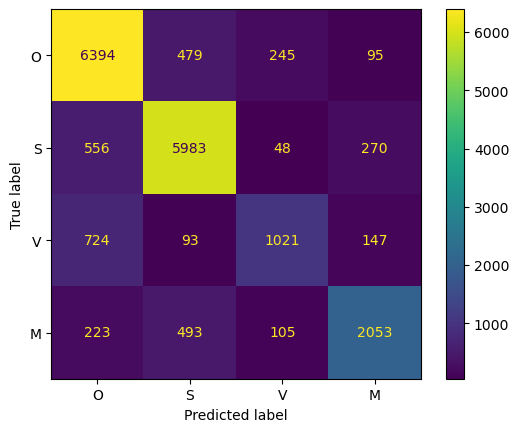

In [32]:
cm=confusion_matrix(ytest,ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['O','S','V','M'])
disp.plot()
plt.show()

In [21]:
mean_f1=np.mean(f1)
std_f1=np.std(f1)
mean_f1, std_f1

(0.7660999458676887, 0.0006646068560663582)

In [22]:
mean_precision=np.mean(precision)
std_precision=np.std(precision)
mean_precision, std_precision

(0.3461486541458451, 0.00015229497530224365)

In [23]:
mean_recall=np.mean(recall)
std_recall=np.std(recall)
mean_recall, std_recall

(0.7473228145155084, 0.0004767432377695068)

In [25]:
mean_ba=np.mean(balanced_accuracy)
std_ba=np.std(balanced_accuracy)
mean_ba, std_ba

(0.7473228145155084, 0.0004767432377695068)

In [26]:
mean_mc=np.mean(mc)
std_mc=np.std(mc)
mean_mc, std_mc

(0.7306347917604934, 0.0007986981161830763)